In [1]:
! pip install -q kaggle
from google.colab import files
files.upload() #upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhamadnady","key":"19fe569424436aaed0139c1b9d435886"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!mkdir -p /content/unzip_file

kaggle.json


In [3]:
# !kaggle kernels list — user YOUR_USER — sort-by dateRun
!kaggle competitions download -c ieee-fraud-detection
!unzip -q train_identity.csv.zip -d /content/unzip_file/
!unzip -q train_transaction.csv.zip -d /content/unzip_file/
!unzip -q test_identity.csv.zip -d /content/unzip_file/
!unzip -q test_transaction.csv.zip -d /content/unzip_file/
!ls

  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 79.5MB/s]
  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 106MB/s]
 79% 41.0M/52.2M [00:00<00:00, 50.3MB/s]
100% 52.2M/52.2M [00:00<00:00, 56.6MB/s]
 70% 41.0M/58.3M [00:00<00:00, 47.8MB/s]
100% 58.3M/58.3M [00:00<00:00, 108MB/s] 
  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 217MB/s]
kaggle.json		   test_identity.csv.zip     train_transaction.csv.zip
sample_data		   test_transaction.csv.zip  unzip_file
sample_submission.csv.zip  train_identity.csv.zip


In [4]:
#!pip install matplotlib-venn
#!apt-get -qq install -y libfluidsynth1
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
sns.set()

In [5]:
train_identity = pd.read_csv('/content/unzip_file/train_identity.csv')
train_transaction = pd.read_csv('/content/unzip_file/train_transaction.csv')

In [6]:
test_identity = pd.read_csv('/content/unzip_file/test_identity.csv')
test_transaction = pd.read_csv('/content/unzip_file/test_transaction.csv')

In [7]:
def downcast_dtype(df):
    _start = df.memory_usage(deep=True).sum() / 1024 ** 2
    float_cols = [c for c in df if df[c].dtype == 'float64']
    int_cols = [c for c in df if df[c].dtype in ['int64', 'int32']]
    df[float_cols] = df[float_cols].astype('float32')
    df[int_cols] = df[int_cols].astype('int32')
    _end = df.memory_usage(deep=True).sum() / 1024 ** 2
    saved = (_start - _end) / _start * 100
    print(f"Save {saved:.2f}%")
    return df

In [8]:
train_identity = downcast_dtype(train_identity)
test_identity = downcast_dtype(test_identity)
train_transaction = downcast_dtype(train_transaction)
test_transaction = downcast_dtype(test_transaction)

Save 8.38%
Save 8.43%
Save 40.75%
Save 40.52%


In [9]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.950001,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.000000,1058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.950012,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.949997,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,0.0,0.0,0.0,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
train_identity.columns

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')

In [12]:
print("train_identity.size", train_identity.size)
print("test_identity.size", test_identity.size)
print("train_identity.shape", train_identity.shape)
print("test_identity.shape", test_identity.shape)
print("train_transaction.size", train_transaction.size)
print("test_transaction.size", test_transaction.size)
print("train_transaction.shape", train_transaction.shape)
print("test_transaction.shape", test_transaction.shape)

train_identity.size 5913553
test_identity.size 5818187
train_identity.shape (144233, 41)
test_identity.shape (141907, 41)
train_transaction.size 232672760
test_transaction.size 199129563
train_transaction.shape (590540, 394)
test_transaction.shape (506691, 393)


In [13]:
data_inmerge = train_transaction[['TransactionID', 'isFraud']].copy()

In [14]:
data_inmerge.shape

(590540, 2)

#Merging two dataframe

In [15]:
train_identity = pd.merge(left=train_identity, right=data_inmerge, how='inner', on='TransactionID', left_index=True)
print('train_identity_shape = ', train_identity.shape)
#print('test_data_shape = ', test_data.shape)

train_identity_shape =  (144233, 42)


In [16]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,isFraud
4,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0
8,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,0
10,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows,0
11,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN,0
16,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS,0


In [17]:
print(train_transaction.info())
print(train_identity.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float32(376), int32(4), object(14)
memory usage: 919.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 144233 entries, 4 to 590534
Data columns (total 42 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int32  
 1   id_01          144233 non-null  float32
 2   id_02          140872 non-null  float32
 3   id_03          66324 non-null   float32
 4   id_04          66324 non-null   float32
 5   id_05          136865 non-null  float32
 6   id_06          136865 non-null  float32
 7   id_07          5155 non-null    float32
 8   id_08          5155 non-null    float32
 9   id_09          74926 non-null   float32
 10  id_10          74926 non-null   float32
 11  id_11          140978 non-null  float32
 12  id_12          144233 non-null  object 
 13  id_13          

In [18]:
train_transaction.isna().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
V335              508189
V336              508189
V337              508189
V338              508189
V339              508189
Length: 394, dtype: int64

In [19]:
train_identity.isna().sum()

TransactionID         0
id_01                 0
id_02              3361
id_03             77909
id_04             77909
id_05              7368
id_06              7368
id_07            139078
id_08            139078
id_09             69307
id_10             69307
id_11              3255
id_12                 0
id_13             16913
id_14             64189
id_15              3248
id_16             14893
id_17              4864
id_18             99120
id_19              4915
id_20              4972
id_21            139074
id_22            139064
id_23            139064
id_24            139486
id_25            139101
id_26            139070
id_27            139064
id_28              3255
id_29              3255
id_30             66668
id_31              3951
id_32             66647
id_33             70944
id_34             66428
id_35              3248
id_36              3248
id_37              3248
id_38              3248
DeviceType         3423
DeviceInfo        25567
isFraud         

In [20]:
train_transaction = train_transaction.dropna(axis = 1, thresh =(len(train_transaction)-100000))
train_identity = train_identity.dropna(axis=1, thresh=(len(train_identity)-70000))
print("train_transaction.shape", train_transaction.shape)
print("train_identity.shape", train_identity.shape)

train_transaction.shape (590540, 182)
train_identity.shape (144233, 29)


In [21]:
def binary_columns(df):
  columns_num = list(df.select_dtypes(include=['float32','int32']).columns)
  for i in df[columns_num]:
    if max(df[i]) == 1:
      yield i
    else:
      pass

In [22]:
binary_columns_tr = list(binary_columns(train_transaction))
binary_columns_id = list(binary_columns(train_identity))

In [23]:
print("binary columns in train transaction data is", binary_columns_tr)
print('binay columns in train identity data is', binary_columns_id)

binary columns in train transaction data is ['isFraud', 'V14', 'V65', 'V88', 'V107']
binay columns in train identity data is ['isFraud']


In [24]:
transaction_corr = train_transaction.corr(method ='pearson')
identity_corr = train_identity.corr(method='pearson')

In [25]:
print("transaction correlation shape: ", transaction_corr.shape)
transaction_corr

transaction correlation shape:  (178, 178)


,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
TransactionID,1.000000,0.014166,0.998280,0.012025,0.010122,-0.019900,-0.010091,-0.023900,-0.000370,0.057213,-0.053154,-0.055186,-0.008896,-0.057235,0.024444,-0.050376,-0.059485,-0.060490,0.033460,-0.062073,-0.054122,-0.058796,-0.017455,-0.043123,0.074338,0.056533,0.071285,0.095513,0.093682,-0.003049,-0.027305,-0.030358,-0.018493,-0.020758,0.012811,0.004417,-0.018802,-0.017885,-0.001733,-0.001529,...,-0.039363,-0.020348,0.020630,0.065149,-0.001737,0.059139,0.044629,0.039437,0.009282,-0.000970,0.001464,0.058846,0.055146,0.064150,0.068249,0.061969,0.069768,0.071569,-0.002652,0.003066,-0.123437,-0.075895,-0.101330,-0.001945,0.058873,0.062254,0.065517,0.007164,0.061176,-0.000008,0.039737,0.030079,0.042570,0.029283,0.057934,0.056887,0.062927,0.017676,0.053150,0.039573
isFraud,0.014166,1.000000,0.013103,0.011320,-0.013640,0.003388,0.154151,-0.033580,0.005596,-0.030387,0.030570,0.037229,-0.006833,0.030382,-0.030754,0.020909,0.028160,0.032139,-0.031703,0.028396,0.027484,0.031905,-0.011146,0.007921,-0.067193,-0.072002,-0.077519,-0.052406,-0.045706,0.002145,0.177963,0.174318,0.182673,0.182550,0.030904,0.040341,0.165985,0.158814,0.149408,0.123824,...,0.104123,0.112731,0.035309,-0.009128,0.004409,0.020417,0.035320,0.042629,0.040149,0.020441,0.026779,-0.004501,0.004241,-0.001681,0.004161,0.002530,0.001294,-0.000308,0.025317,0.032087,0.132903,0.124287,0.131498,-0.000496,-0.001863,0.005948,0.003253,0.020256,0.011071,0.001300,0.037578,0.041494,0.038535,0.048298,-0.002960,0.005010,0.000997,0.000061,0.004961,0.001677
TransactionDT,0.998280,0.013103,1.000000,0.011920,0.010625,-0.019202,-0.011222,-0.024132,-0.000051,0.051972,-0.049318,-0.051126,-0.007546,-0.053104,0.023800,-0.046612,-0.055402,-0.056288,0.032732,-0.057734,-0.050181,-0.054738,-0.015022,-0.039721,0.074031,0.058409,0.072791,0.095749,0.094036,-0.003224,-0.028838,-0.031519,-0.019005,-0.021017,0.010554,0.002733,-0.019356,-0.018188,-0.001374,-0.000842,...,-0.038917,-0.020027,0.020175,0.065558,-0.002191,0.059488,0.043712,0.038405,0.008914,-0.001211,0.001264,0.061212,0.057413,0.066788,0.070909,0.064545,0.072516,0.074405,-0.001938,0.003628,-0.119438,-0.072278,-0.097353,-0.001819,0.061252,0.064581,0.068148,0.007056,0.061206,-0.000028,0.039969,0.029642,0.042646,0.028649,0.060300,0.059212,0.065552,0.018373,0.055153,0.041065
TransactionAmt,0.012025,0.011320,0.011920,1.000000,-0.005725,0.016136,-0.109785,0.003061,-0.007421,0.028312,-0.017722,-0.018468,-0.004798,-0.010148,-0.030560,-0.016982,-0.017061,-0.014820,-0.030021,-0.015958,-0.017313,-0.017135,-0.040034,-0.022435,-0.039985,-0.038982,-0.054735,0.083627,0.074821,0.001254,-0.139413,-0.136391,-0.123743,-0.122237,0.025335,0.020159,-0.128871,-0.124262,0.016379,0.011956,...,0.054721,0.025815,-0.019570,-0.045777,-0.015060,-0.036349,-0.025668,-0.025926,-0.009843,-0.008628,-0.009589,-0.005055,-0.007863,-0.006262,-0.001689,0.027644,-0.000657,0.005789,0.072510,0.066573,-0.112344,-0.103603,-0.109847,0.002380,0.035330,0.029512,0.034060,0.084632,0.106194,0.054091,0.107135,0.190256,0.148143,0.176778,0.013058,0.010584,0.013408,0.128373,0.103606,0.120679
card1,0.010122,-0.013640,0.010625,-0.005725,1.000000,0.004960,0.002965,-0.093633,0.020369,-0.000060,0.005716,0.005199,-0.004710,0.005193,0.005752,0.006575,0.004641,0.004645,0.004370,0.003794,0.005808,0.004210,0.004300,0.007366,-0.006619,-0.000844,-0.004846,-0.002329,-0.001402,-0.001578,0.002698,0.002645,0.007164,0.006935,-0.002691,-0.001004,0.006765,0.001126,-0.005029,-0.000833,...,0.012535,0.015171,0.000331,0.006005,-0.004300,0.007748,0.009162,0.004322,0.014904,0.011672,0.012512,0.046446,0.050478,0.052909,0.05019

In [26]:
print("identity correlaton shape: ", identity_corr.shape)
identity_corr

identity correlaton shape:  (15, 15)


,TransactionID,id_01,id_02,id_05,id_06,id_09,id_10,id_11,id_13,id_14,id_17,id_19,id_20,id_32,isFraud
TransactionID,1.000000,-0.094145,0.170335,-0.061198,-0.026956,-0.032954,0.009245,0.031831,0.085015,0.043151,0.222829,-0.015030,0.084105,-0.066437,0.092935
id_01,-0.094145,1.000000,-0.142064,0.009666,0.201637,0.029174,0.050737,0.014453,0.088596,-0.085331,-0.180504,0.000519,-0.071238,-0.004386,-0.120099
id_02,0.170335,-0.142064,1.000000,-0.101547,-0.047041,-0.020656,0.017490,0.053775,-0.035814,-0.037694,0.412987,-0.093068,0.108523,0.130711,0.049398
id_05,-0.061198,0.009666,-0.101547,1.000000,-0.291584,0.085882,-0.070985,-0.043037,-0.036637,-0.001985,-0.203021,-0.023800,-0.058070,0.099603,-0.007978
id_06,-0.026956,0.201637,-0.047041,-0.291584,1.000000,0.079989,0.222372,0.020841,0.074835,-0.029647,-0.028708,0.029647,-0.071015,-0.086302,-0.027139
id_09,-0.032954,0.029174,-0.020656,0.085882,0.079989,1.000000,0.316010,-0.037671,0.014582,-0.006684,-0.023937,-0.008878,-0.006150,-0.029533,0.029431
id_10,0.009245,0.050737,0.017490,-0.070985,0.222372,0.316010,1.000000,0.070048,-0.023759,-0.011014,0.038112,-0.030461,0.018121,0.056037,0.011043
id_11,0.031831,0.014453,0.053775,-0.043037,0.020841,-0.037671,0.070048,1.000000,-0.063270,0.017037,0.062694,0.004050,0.036314,0.152434,0.007914
id_13,0.085015,0.088596,-0.035814,-0.036637,0.074835,0.014582,-0.023759,-0.063270,1.000000,-0.031033,-0.075997,0.017657,-0.029427,-0.208539,-0.019538
id_14,0.043151,-0.085331,-0.037694,-0.001985,-0.029647,-0.006684,-0.011014,0.017037,-0.031033,1.000000,-0.086848,-0.074575,0.358147,-0.015527,0.057324


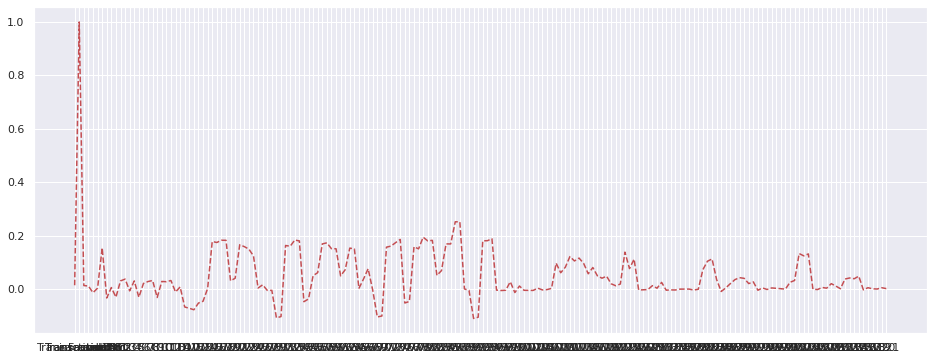

In [27]:
TcorrwithTarget = train_transaction.corrwith(train_transaction['isFraud'])
plt.figure(figsize=(16, 6))
plt.plot(TcorrwithTarget.index, TcorrwithTarget.values, 'r--')

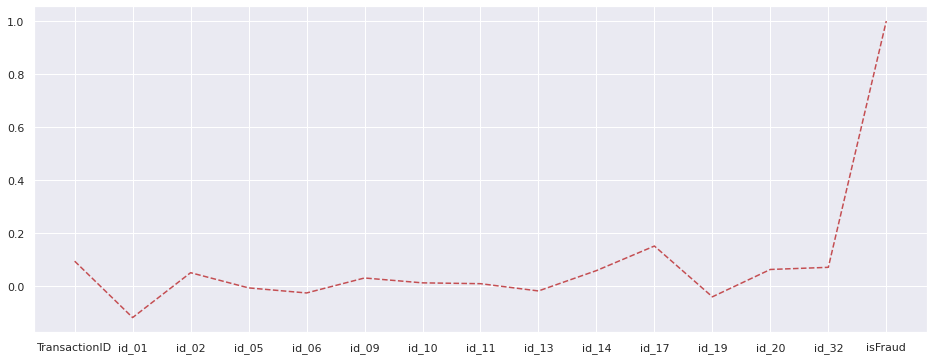

In [28]:
IcorrwithTarget = train_identity.corrwith(train_identity['isFraud'])
plt.figure(figsize=(16, 6))
plt.plot(IcorrwithTarget.index, IcorrwithTarget.values, 'r--')

#Remove highly correlated features

In [29]:
def remove_redundancies(corr):
  correlated_features = set()
  correlation_matrix = corr
  for i in range(len(correlation_matrix .columns)):
      for j in range(i):
          if abs(corr.iloc[i, j]) > 0.9:
              colname = corr.columns[i]
              correlated_features.add(colname)
  return correlated_features

In [30]:
Tcorrelated_features = remove_redundancies(transaction_corr)
Icorrelated_features = remove_redundancies(identity_corr)

In [31]:
train_transaction.drop(labels=Tcorrelated_features, axis=1, inplace=True)
train_identity.drop(labels = Icorrelated_features, axis =1, inplace=True)
#test_features.drop(labels=correlated_features, axis=1, inplace=True)

In [32]:
print("train_transaction.shape ", train_transaction.shape)
print("train_identity.shape ", train_identity.shape)

train_transaction.shape  (590540, 96)
train_identity.shape  (144233, 29)


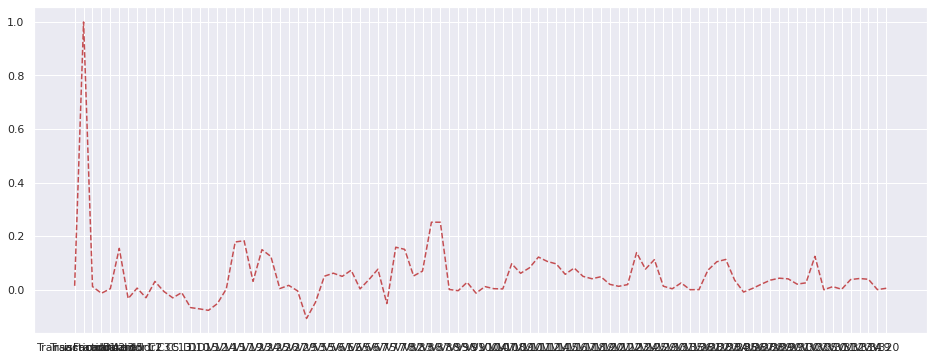

In [33]:
TcorrwithTarget = train_transaction.corrwith(train_transaction['isFraud'])
plt.figure(figsize=(16, 6))
plt.plot(TcorrwithTarget.index, TcorrwithTarget.values, 'r--')

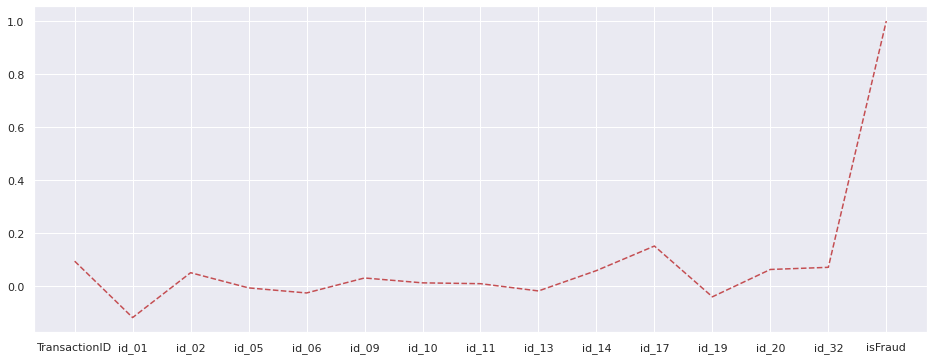

In [34]:
IcorrwithTarget = train_identity.corrwith(train_identity['isFraud'])
plt.figure(figsize=(16, 6))
plt.plot(IcorrwithTarget.index, IcorrwithTarget.values, 'r--')

#Fill null values

In [35]:
def colwithnul(df):
  col_nem = list(df.select_dtypes(include=['float32','int32']).columns)
  #col_nem.remove('TransactionID')
  #col_nem.remove('isFraud')
  return col_nem

In [36]:
Tcolnum = colwithnul(train_transaction)
Icolnum = colwithnul(train_identity)

In [37]:
# Columns which gonna fill with mean
def fillnullmean(df, colnum, binary_column):
  colnum = [item for item in colnum if item not in binary_column]
  for i in colnum:
    z_high = []
    z_score = stats.zscore(df[i])
    [z_high.append(a) for a in abs(z_score) if a > 3]
    if len(z_high) < 5:
      #print(len(z_high))
      df[i].fillna(df[i].mean(), inplace=True)
    else:
      print(i, len(z_high))
      pass

In [38]:
# Columns which gonna fill with mode
def fillnullmod(df, binary_column):
  binary_column.remove('isFraud')
  for i in binary_column:
    z_high = []
    z_score = stats.zscore(df[i])
    [z_high.append(a) for a in abs(z_score) if a > 3]
    if len(z_high) < 5:
      #print(len(z_high))
      df[i].fillna(df[i].mode(), inplace=True)
    else:
      print(i, len(z_high))
      pass


In [39]:
fillnullmean(df=train_transaction, colnum=Tcolnum, binary_column=binary_columns_tr)
fillnullmean(df=train_identity, colnum=Icolnum, binary_column=binary_columns_id)

TransactionAmt 10093
C1 2024
C3 2429
C5 19399
C13 19701
id_01 3000


In [40]:
fillnullmod(df=train_transaction, binary_column=binary_columns_tr)
fillnullmod(df=train_identity, binary_column=binary_columns_id)

In [41]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(train_transaction.isna().sum())

TransactionID         0
isFraud               0
TransactionAmt        0
ProductCD             0
card1                 0
card2                 0
card3                 0
card4              1577
card5                 0
card6              1571
addr1                 0
addr2                 0
P_emaildomain     94456
C1                    0
C3                    0
C5                    0
C13                   0
D1                    0
D10                   0
D15                   0
V12                   0
V14               76073
V15                   0
V17                   0
V19                   0
V23                   0
V24                   0
V25                   0
V26                   0
V27                   0
V29                   0
V53                   0
V55                   0
V56                   0
V61                   0
V62                   0
V65               77096
V66                   0
V67                   0
V75                   0
V77                   0
V78             

In [42]:
train_identity.isna().sum()

TransactionID        0
id_01                0
id_02                0
id_05                0
id_06                0
id_09                0
id_10                0
id_11                0
id_12                0
id_13                0
id_14                0
id_15             3248
id_16            14893
id_17                0
id_19                0
id_20                0
id_28             3255
id_29             3255
id_30            66668
id_31             3951
id_32                0
id_34            66428
id_35             3248
id_36             3248
id_37             3248
id_38             3248
DeviceType        3423
DeviceInfo       25567
isFraud              0
dtype: int64

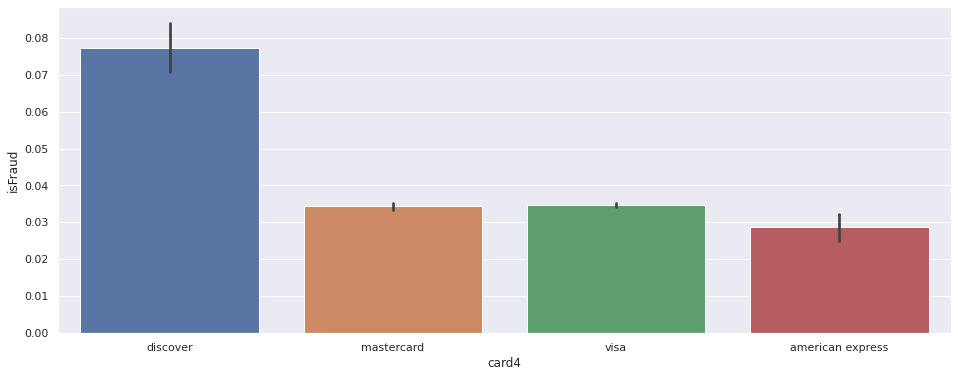

In [43]:
plt.figure(figsize=(16, 6))
sns.barplot(x='card4', y='isFraud', data=train_transaction)
#plt.bar(train_transaction['card4'].unique(), train_transaction['isFraud'])

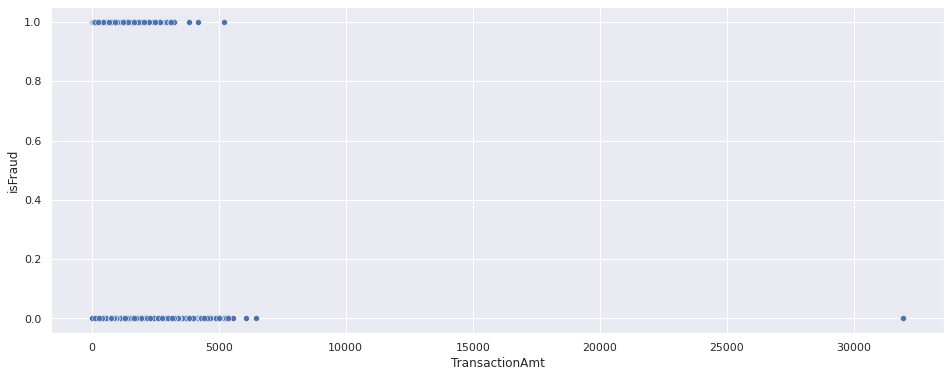

In [44]:
plt.figure(figsize=(16, 6))
sns.scatterplot(x='TransactionAmt', y='isFraud', data=train_transaction)


In [45]:
print(train_transaction['card4'].dtypes)
print(train_transaction['P_emaildomain'].dtypes)

object
object


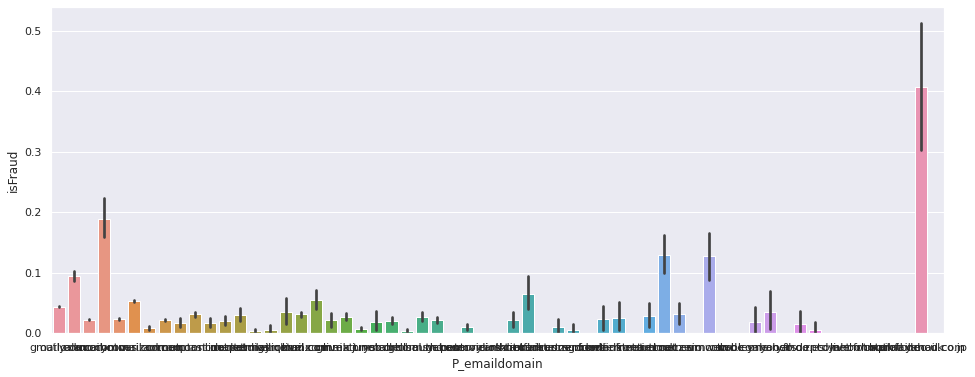

In [46]:
plt.figure(figsize=(16,6))
sns.barplot(x='P_emaildomain', y='isFraud', data=train_transaction)

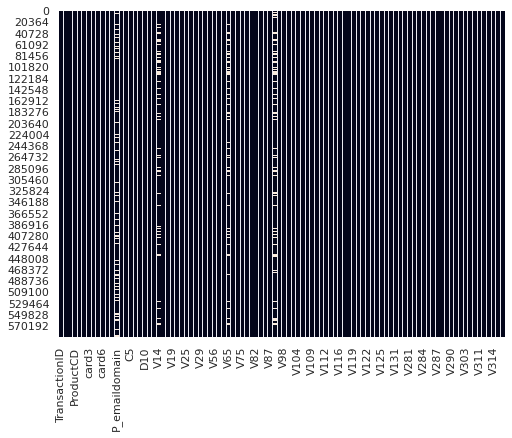

In [55]:
fig_dims = (8, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(train_transaction.isnull(), cbar=False)

In [50]:
train_transaction.head(10)

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,C1,C3,C5,C13,D1,D10,D15,V12,V14,V15,V17,V19,V23,V24,V25,V26,V27,V29,V53,V55,V56,V61,V62,V65,V66,V67,V75,V77,V78,V82,V83,V86,V87,V88,V95,V98,V99,V100,V104,V107,V108,V109,V110,V111,V112,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V129,V130,V131,V135,V136,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V300,V303,V305,V310,V311,V312,V313,V314,V319,V320
0,2987000,0,68.5,W,13926,362.583649,150.0,discover,142.0,credit,315.0,87.0,NaN,1.0,0.0,0.0,1.0,14.0,13.000000,0.000000,1.000000,1.0,0.000000,0.00000,1.000000,1.000000,1.000000,1.00000,1.00000,0.000000,0.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.00000,0.000000,1.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987001,0,29.0,W,2755,404.000000,150.0,mastercard,102.0,credit,325.0,87.0,gmail.com,1.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.00000,1.000000,1.000000,1.000000,1.00000,1.00000,0.000000,0.00000,0.000000,1.00000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,59.0,W,4663,490.000000,150.0,visa,166.0,debit,330.0,87.0,outlook.com,1.0,0.0,0.0,1.0,0.0,0.000000,315.000000,1.000000,1.0,0.000000,0.00000,1.000000,1.000000,1.000000,1.00000,1.00000,0.000000,0.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,50.0,W,18132,567.000000,150.0,mastercard,117.0,debit,476.0,87.0,yahoo.com,2.0,0.0,0.0,25.0,112.0,84.000000,111.000000,1.000000,1.0,0.000000,0.00000,1.000000,1.000000,1.000000,1.00000,1.00000,0.000000,0.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.0,1.0,0.0,10.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,354.0,135.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,354.0,0.0,135.0,0.0,0.0,0.0,0.0
4,2987004,0,50.0,H,4497,514.000000,150.0,mastercard,102.0,credit,420.0,87.0,gmail.com,1.0,0.0,0.0,1.0,0.0,123.977188,163.738007,0.559711,NaN,0.122342,0.13404,0.816371,1.034791,1.058097,0.97766,0.98804,0.000776,0.38784,0.577586,1.06767,1.120979,0.829785,0.867563,NaN,0.981038,0.998121,0.544278,1.086893,1.144462,0.84461,0.881965,1.064885,1.099456,NaN,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,49.0,W,5937,555.000000,150.0,visa,226.0,debit,272.0,87.0,gmail.com,1.0,0.0,0.0,1.0,0.0,0.000000,0.000000,1.000000,1.0,0.000000,0.00000,1.000000,1.000000,1.000000,1.00000,1.00000,0.000000,0.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2987006,0,159.0,W,12308,360.000000,150.0,visa,166.0,debit,126.0,87.0,yahoo.com,1.0,0.0,0.0,1.0,0.0,0.000000,0.000000,1.000000,1.0,0.000000,0.00000,1.000000,1.000000,1.000000,1.00000,1.00000,0.000000,0.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.0,1.

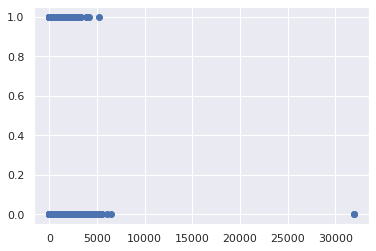

In [52]:
plt.plot(train_transaction['TransactionAmt'], train_transaction['isFraud'], "bo")

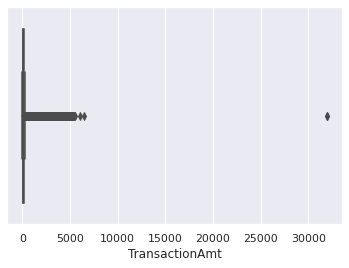

In [53]:
sns.boxplot(x = train_transaction['TransactionAmt'])

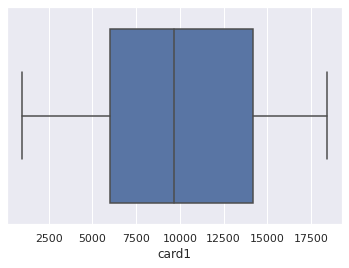

In [54]:
sns.boxplot(x = train_transaction['card1'])

In [ ]:
[(index, value) for index, value  in corrwithTarget.items() if value > .2]